<a href="https://colab.research.google.com/github/cgoeser1/MSDS422_course_assignments/blob/main/AmesHousing(2021OCT10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conduct EDA on the dataset as follows:**
* Provide appropriate descriptive statistics and visualizations to help understand the **marginal distribution** of the dependent variable.
* Investigate **missing data** and **outliers**.
* Investigate at least **three potential predictors** of the dependent variable and provide appropriate graphs / statistics to demonstrate the relationships.
* Engage in **feature creation** by splitting, merging, or otherwise generating a new predictor.
* Using the dependent variable, perform both **min-max and standard scaling** in Python.
#Checkpoint 2
* Conduct your analysis using a **cross-validation** design.
* Conduct EDA and provide appropriate **visualizations** in the process.
* Build a minimum of **two separate regression models** using the training set.
* Evaluate **polynomial, indicator, dichotomous, & piecewise** model components.
* **Create at least one feature** from the data set.
* Evaluate the models’ **assumptions**.
* Evaluate **goodness of fit** metrics on the training and validation sets.
* Submit predictions for the unseen test set available on **Kaggle.com**.
* Provide your Kaggle user name and a screen snapshot of your **Kaggle scores**.
* Discuss what your models tell you in **layman’s terms**

Import all relevant packages.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

Clone the repository, so all files are in the same folder.  Should be accessible to all collaborators.

In [2]:
!git clone https://github.com/cgoeser1/MSDS422_course_assignments


Cloning into 'MSDS422_course_assignments'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


Change the Colab working directory to that just cloned from GitHub.
Confirm the working directory.

In [3]:
os.chdir('/content/MSDS422_course_assignments')
os.getcwd()

'/content/MSDS422_course_assignments'


Load train and test files into Pandas dataframes.

In [4]:
## Get data from the provided CSV files.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Check the number of observations for each feature in the 'train' set.

[Text(0.5, 1.0, 'SalePrice - High')]

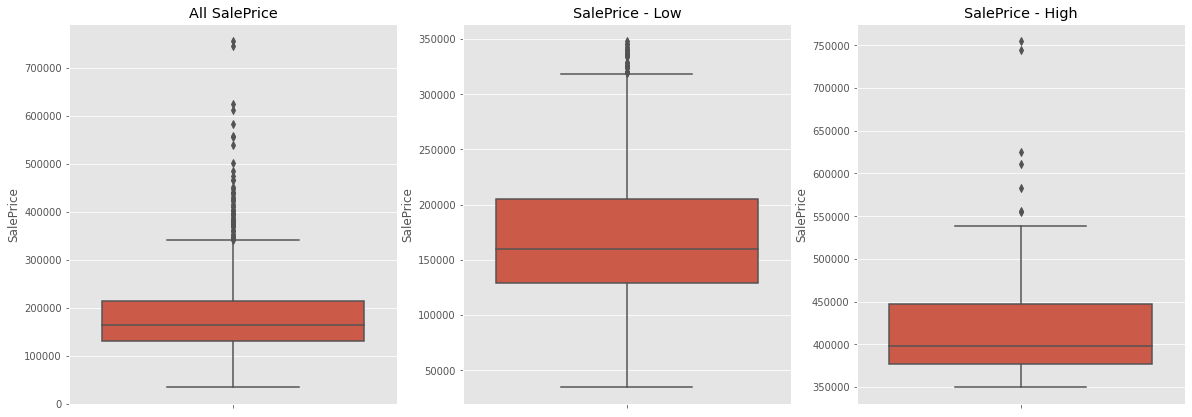

In [5]:
## Check for Outliers. It looks like $350,000 is the max of IQR, 
## so it may make sense to split into two sets ('low' and 'high') based on this price.
train_low = train[train.SalePrice<350000]
train_hi = train[train.SalePrice>=350000]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,7), sharey=False)
sns.boxplot(y=train['SalePrice'], data=train, ax=ax0).set(title='All SalePrice')
sns.boxplot(y=train_low['SalePrice'], data=train_low, ax=ax1).set(title='SalePrice - Low')
sns.boxplot(y=train_hi['SalePrice'], data=train_hi, ax=ax2).set(title='SalePrice - High')

In [6]:
### **Investigate missing data.
## count the number of features.
print(len(train.columns))
train.info()

81
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  Overa

### **Marginal distribution of the SalePrice.**

In [7]:
## Do a quick statistical summary of the train data set SalePrice. -cpg
print(f"Mean Housing Price: ${train.SalePrice.mean():,.2f}.")
print(f"Median Housing Price: ${train.SalePrice.median():,.2f}.")

Mean Housing Price: $180,921.20.
Median Housing Price: $163,000.00.


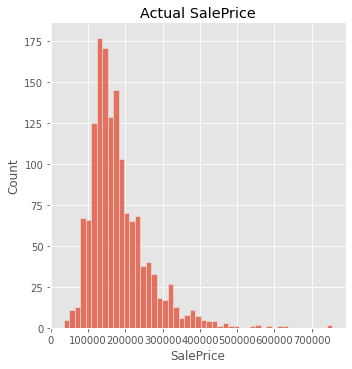

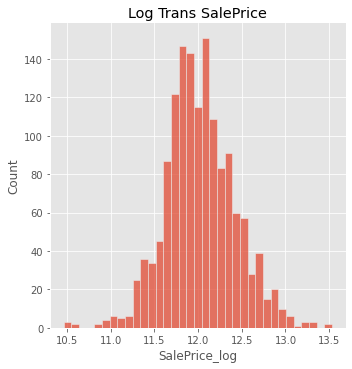

In [8]:
## Count the SalesPrice observations and plot, looking at the SalePrice and log-transformed SalePrice. 
## In SalePrice, we see right skew, due to a tail of more expensive houses. 
## We then try to normalize the distribution with a log transformation.
train['SalePrice_log'] = np.log(train.SalePrice)
sns.displot(train.SalePrice).set(title='Actual SalePrice')
sns.displot(train.SalePrice_log).set(title='Log Trans SalePrice')



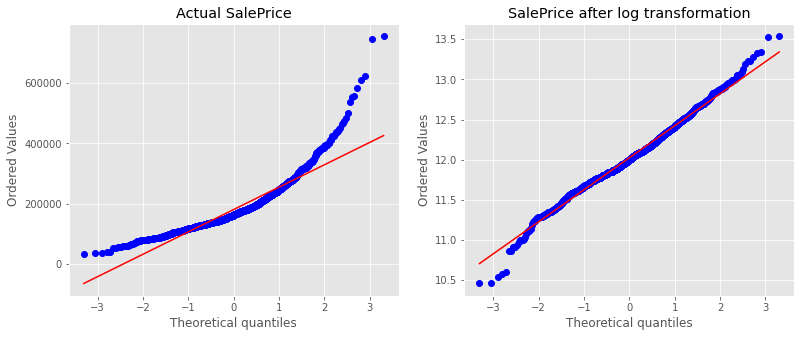

<Figure size 432x288 with 0 Axes>

In [9]:
## Fit the SalePrice and log-transformed SalePrice to a normal curve.  
## 'probplot' plots data against a normal distribution.
figure = plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
stats.probplot(train.SalePrice, plot = plt)
plt.title('Actual SalePrice')
plt.subplot(1,2,2)
stats.probplot(train.SalePrice_log, plot = plt)
plt.title('SalePrice after log transformation')
plt.show()
plt.savefig('SalePrice.jpg')

## **Investigate Outliers**

In [10]:
## Check for Outliers. It looks like $350,000 is the max of IQR, 
## so it may make sense to split into two sets ('low' and 'high') based on this price.
train_low = train[train.SalePrice<350000]
train_hi = train[train.SalePrice>=350000]

[Text(0.5, 1.0, 'SalePrice - High')]

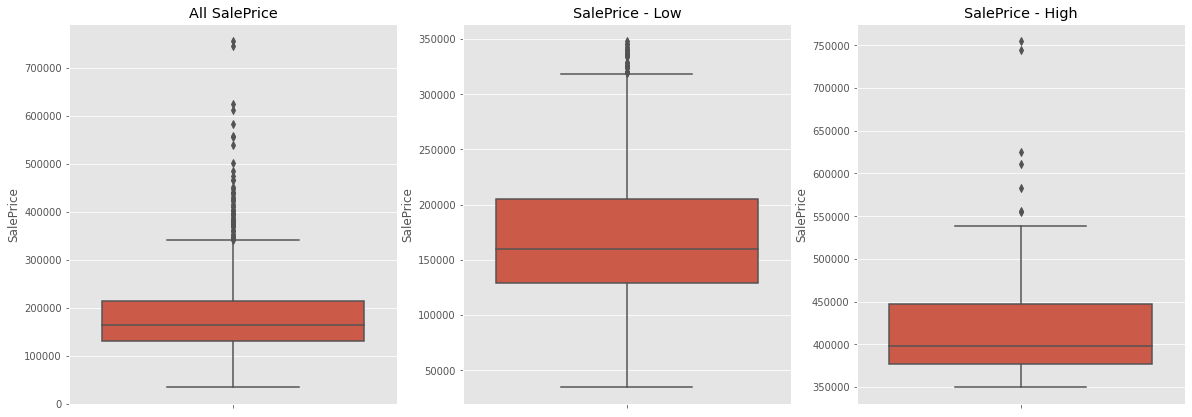

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,7), sharey=False)
sns.boxplot(y=train['SalePrice'], data=train, ax=ax0).set(title='All SalePrice')
sns.boxplot(y=train_low['SalePrice'], data=train_low, ax=ax1).set(title='SalePrice - Low')
sns.boxplot(y=train_hi['SalePrice'], data=train_hi, ax=ax2).set(title='SalePrice - High')

### **Investigate missing data.**

In [12]:
## Identify the features missing values, so we can determine whether to drop the feature or impute the data.
## Will revisit dropping features later.  Prof. Anil suggests that we can do it better
## by determing the "degree of randomness" of the missing data. 
missing = train.isna().sum()
missing = missing[missing>0]
missing_perc = missing/train.shape[0]*100
missinglist = pd.DataFrame([missing, missing_perc], index = ['missing_num', 'missing_perc']).T
missinglist = missinglist.sort_values(by = 'missing_perc', ascending = False)
print(missinglist)

              missing_num  missing_perc
PoolQC             1453.0     99.520548
MiscFeature        1406.0     96.301370
Alley              1369.0     93.767123
Fence              1179.0     80.753425
FireplaceQu         690.0     47.260274
LotFrontage         259.0     17.739726
GarageType           81.0      5.547945
GarageYrBlt          81.0      5.547945
GarageFinish         81.0      5.547945
GarageQual           81.0      5.547945
GarageCond           81.0      5.547945
BsmtExposure         38.0      2.602740
BsmtFinType2         38.0      2.602740
BsmtFinType1         37.0      2.534247
BsmtCond             37.0      2.534247
BsmtQual             37.0      2.534247
MasVnrArea            8.0      0.547945
MasVnrType            8.0      0.547945
Electrical            1.0      0.068493


### **Consider Imputing and/or dropping features.**

In [13]:

### **Consider Imputing and/or dropping features.**
  ## replace na with 0 for the folowing columns 
train['BsmtUnfSF']= train['BsmtUnfSF'].fillna(0)
train['TotalBsmtSF']= train['TotalBsmtSF'].fillna(0)
train['GarageArea']= train['GarageArea'].fillna(0)
train['GarageCars']= train['GarageCars'].fillna(0)
train['BsmtFinSF1']= train['BsmtFinSF1'].fillna(0)
train['BsmtFinSF2']= train['BsmtFinSF2'].fillna(0)
train['LotFrontage']= train['LotFrontage'].fillna(0)
train['BsmtFullBath']= train['BsmtFullBath'].fillna(0)
train['BsmtHalfBath']= train['BsmtHalfBath'].fillna(0)
train['MasVnrArea']= train['MasVnrArea'].fillna(0)
  ## for the rest of the columns it looks like NA is input when the feature is missing so we will replace NA values with 
  ## 'no feature'. This is done to create dummy values.
train = train.fillna('No feature')
## Drop GarageYrBlt column 
train = train.drop(columns=['GarageYrBlt'])
train = train.drop(columns=['SalePrice_log'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
## Drop those features.
## train.drop(droplist, axis = 1, inplace = True)

### **Engage in feature creation by splitting, merging, or otherwise generating a new predictor.**

In [15]:
### **Engage in feature creation by splitting, merging, or otherwise generating a new predictor.**

## Create some features to summarize some that seem fractured.
# find the Age of the house at the sell year. -AA
train['HouseAge'] = train['YrSold']-train['YearBuilt']
## get total number of rooms, above and below grade.
## then remove component features.
train['TotalBathrooms'] = train['BsmtFullBath']+train['BsmtHalfBath']+train['FullBath']+train['HalfBath']
train = train.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1)
## Total Square Footage; and drop components
train['TotalSF'] = train['TotalBsmtSF']+train['1stFlrSF']+train['2ndFlrSF']
train.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF', 'BsmtFinSF1','BsmtFinSF2','LowQualFinSF'], axis=1, inplace=True)

In [16]:
## Putting Target Feature in the last position of dataframe for easy reference in heatmap. -cpg
last_column = train.pop('SalePrice')
train['SalePrice']=last_column

### **View the correlation between select features and target.**

Text(0.5, 1.0, 'Heatmap Sale Price')

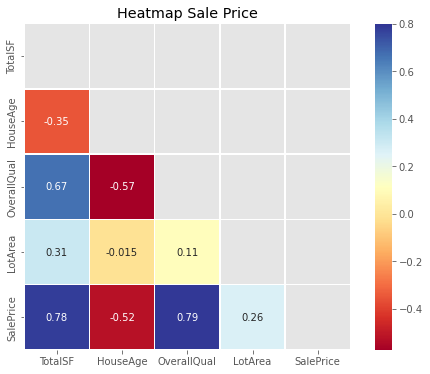

In [17]:
### **View the UNSCALED correlation between select features and target.**

# Create a correlation heatmap to find out which 4 variables -AA (Chad added sq ft)
# "HouseAge", "OverallQual", "LotArea" is more correlated with "SalePrice" 
# Create a df for correlation.
columns = ['TotalSF', 'HouseAge','OverallQual','LotArea','SalePrice']
df_corr = train[columns]
# setting up the heatmap
corrmat = df_corr.corr()

# mask similar squares
mask = np.triu(np.ones_like(corrmat,dtype=bool))

# set the figure size
f, ax = plt.subplots(figsize=(9, 6))

# pass the data and set the parameters
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap='RdYlBu', linewidths=.5, mask=mask)
plt.title('Heatmap Sale Price')

In [18]:
## Another way to view the correlation between features and target. -cpg
## Categorical features are not represented... need to convert via dummies.
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.790982
TotalSF           0.782260
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBathrooms    0.613005
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
Fireplaces        0.466929
WoodDeckSF        0.324413
OpenPorchSF       0.315856
LotArea           0.263843
BsmtUnfSF         0.214479
LotFrontage       0.209624
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
MoSold            0.046432
3SsnPorch         0.044584
MiscVal          -0.021190
Id               -0.021917
YrSold           -0.028923
OverallCond      -0.077856
MSSubClass       -0.084284
EnclosedPorch    -0.128578
KitchenAbvGr     -0.135907
HouseAge         -0.523350
Name: SalePrice, dtype: float64

In [19]:
## Look at scatter matrix of some higher correlated features. -cpg
##from pandas.plotting import scatter_matrix
##top_five_features = ['OverallCond','OverallQual','TotalSF','GrLivArea', 'HouseAge','GarageCars','SalePrice']
##scatter_matrix(train[top_five_features], figsize=(20, 15))

In [20]:
## EDA focus in on one of the higher correlated features. -cpg
## f = train.plot(kind="scatter", x="TotalSF", y="SalePrice", alpha=0.1,figsize=(9, 6))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **View the non-numerical features. GetDummies, etc., for all non-numerical data.**

In [21]:
## Separate numerical and non-numerical features.
non_numerical = train.select_dtypes(exclude=['int64','float64'])
numerical = train.select_dtypes(exclude=['object'])
## Show how many unique values within each non-numerical feature.
non_numerical.astype(str)
non_numerical.nunique(dropna=False)


MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

In [22]:
non_numerical.head(2)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,No feature,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,No feature,Attchd,RFn,TA,TA,Y,No feature,No feature,No feature,WD,Normal
1,RL,Pave,No feature,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,No feature,No feature,No feature,WD,Normal


In [23]:
## Show list of non-numerical feature names.
columns_1hot = non_numerical.columns.to_list()
print(columns_1hot)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [24]:
# get dummy variables for all cat. variables
dummies = pd.get_dummies(train[columns_1hot])
#drop categorical columns and the Id
train = train.drop(columns= columns_1hot)
# create a new df with dummy variables
train_with_dummies = pd.concat([train,dummies], axis= 'columns')
train_with_dummies.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,HouseAge,TotalBathrooms,TotalSF,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No feature,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No feature,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No feature,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_No feature,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No feature,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No feature,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No feature,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_No feature,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No feature,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_

In [25]:
train_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 298 entries, Id to SaleCondition_Partial
dtypes: float64(2), int64(28), uint8(268)
memory usage: 724.4 KB


In [26]:
# drop one of the dummy variable columns so we don't have a dummy variable trap.
train_with_dummies = train_with_dummies.drop('SaleCondition_Normal', axis = 1)
train_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 297 entries, Id to SaleCondition_Partial
dtypes: float64(2), int64(28), uint8(267)
memory usage: 723.0 KB


In [27]:
## Putting Target Feature in the last position of dataframe for easy reference.
last_column = train.pop('SalePrice')
train['SalePrice']=last_column
##train.info()

# **Scale the features.**

In [28]:
### perform standard scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [29]:
# perform standard scaling transformation   

#x = train_with_dummies.values
#Standard_Scaler = StandardScaler().fit(x)
#train_scaled = DataFrame(Standard_Scaler)
#train_scaled.info()

train_scaled = train_with_dummies
col_names = train_with_dummies.columns.to_list()
## We remove the target feature from scaling. -cpg
col_names.remove('SalePrice')
## We remove the ID column as it is not a feature. -cpg
col_names.remove('Id')
features = train_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
train_scaled[col_names] = features
train_scaled.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,HouseAge,TotalBathrooms,TotalSF,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No feature,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No feature,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No feature,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_No feature,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No feature,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No feature,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No feature,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_No feature,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No feature,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_

In [30]:
## Look at the correlation with Target after scaling.
corr_matrix = train_scaled.corr()
keep_features = corr_matrix["SalePrice"].sort_values(ascending=False).to_frame()
##train_scaled_keep = keep_features[keep_features['SalePrice']>=0.5]
train_scaled_keep_list = keep_features[keep_features['SalePrice']>=0.1].index.to_list()
train_scaled_keep_list.remove('SalePrice')
len(train_scaled_keep_list)

71

### From the correlation matrix we pick only the variables that have a |correlation coef.| > 0.5 for the model:
- OverallQual, TotalSF, GrLivArea, GarageCars, GarageArea, TotalBathrooms, TotRmsAbvGrd, YearBuilt, YearRemodAdd, HouseAge 
### ...plus the dummy variable columns.

In [31]:
# Create the predictors and response for the model
y = train_scaled['SalePrice']
x = train_scaled[train_scaled_keep_list]


In [32]:
len(x.columns)

71

In [33]:
# split data for cross-validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state=31)

In [34]:
## Loading in the statsmodels package to do a quick check on the train data set.
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [35]:
## statsmodels uses Patsy package to describe our model.
## the first position is the target, and 'x' contains all relevant features.
est = smf.ols('SalePrice ~ x ', train).fit()
##print(est.params)
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     138.3
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:20:25   Log-Likelihood:                -17019.
No. Observations:                1460   AIC:                         3.418e+04
Df Residuals:                    1388   BIC:                         3.456e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.809e+05    750.055    241.210      0.0

## From the results above we can conclude that some of the predictors have no relation with the response because the t value is low which makes the p value too high. The R^2 of the model is 0.808


In [36]:
# Using sklearn linear regression module:

## Build the model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(181441.93257511852,
 array([ 12738.69066352,   3983.45279285,  18623.63507068,  11638.01183632,
         -4253.40860459,   4633.64020314,   6789.15730764,   5664.24331595,
          1966.32722921,   2430.41253282,   8037.46075531,  -2016.33870476,
          3475.7168439 ,   2393.79809094,   1665.04618648,   2395.81691985,
          1552.39017072,   2306.20474391,    235.41896527,   9387.74380556,
         14447.3090212 , -11608.42712334,    718.32391718,    986.03650772,
         -1969.0473075 ,   8801.44927655,   1684.94277815,   2470.03338455,
          1058.97933321,   6590.08508622,   3341.06340892,  -1308.84226075,
           962.80641814,   3659.8135775 ,   -331.87476634,    520.08110772,
         -1468.24427337,   2463.65608267,  -6008.05442193,    165.20794431,
           958.04271615,   -446.75776344,    398.01541113,   1352.87784605,
           281.08659709,   8600.13929935,  -3059.44103939,  -3164.26601019,
         -2219.8324839 ,    304.48347111,   -655.78407463,   3210.0

In [37]:
y_test_predic = lin_reg.predict(x_test)

In [38]:
# create a dataframe with the predicted sale price for the x_test and the actual prices from y_test

cross_val_df = pd.DataFrame(y_test_predic, columns = ['PredictedPrice'])
cross_val_df['ActualPrice']= y_test.values
cross_val_df.head()

,PredictedPrice,ActualPrice
0,239979.585087,200500
1,137569.992271,144000
2,104754.978561,147000
3,135559.802972,138887
4,120071.950536,119900


In [39]:
# find the correlation between the two
cross_val_df.corr()

,PredictedPrice,ActualPrice
PredictedPrice,1.000000,0.923707
ActualPrice,0.923707,1.000000


In [40]:
# Calculate R^2
correl = 0.923707
R_sq = correl*correl
R_sq

0.8532346218489999

## We can see that the R^2 of the models is near 0.81 (0.808 and 0.810, respectively)

### **Let us prepare the test dataset**

In [41]:

test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [42]:
### **Consider Imputing and/or dropping features.**
  ## replace na with 0 for the folowing columns 
test['BsmtUnfSF']= test['BsmtUnfSF'].fillna(0)
test['TotalBsmtSF']= test['TotalBsmtSF'].fillna(0)
test['GarageArea']= test['GarageArea'].fillna(0)
test['GarageCars']= test['GarageCars'].fillna(0)
test['BsmtFinSF1']= test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2']= test['BsmtFinSF2'].fillna(0)
test['LotFrontage']= test['LotFrontage'].fillna(0)
test['BsmtFullBath']= test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath']= test['BsmtHalfBath'].fillna(0)
test['MasVnrArea']= test['MasVnrArea'].fillna(0)
  ## for the rest of the columns it looks like NA is input when the feature is missing so we will replace NA values with 
  ## 'no feature'. This is done to create dummy values.
test = test.fillna('No feature')
## Drop GarageYrBlt column 
test = test.drop(columns=['GarageYrBlt'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [43]:
# find the Age of the house at the sell year. -AA
test['HouseAge'] = test['YrSold']-test['YearBuilt']
## get total number of rooms, above and below grade.
## then remove component features.
test['TotalBathrooms'] = test['BsmtFullBath']+test['BsmtHalfBath']+test['FullBath']+test['HalfBath']
test = test.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1)
## Total Square Footage; and drop components
test['TotalSF'] = test['TotalBsmtSF']+test['1stFlrSF']+test['2ndFlrSF']
test.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF', 'BsmtFinSF1','BsmtFinSF2','LowQualFinSF'], axis=1, inplace=True)

In [44]:
### **View the non-numerical features.**

## Get list of non-numerical features.
non_numerical = test.select_dtypes(exclude=['int64','float64'])
numerical = test.select_dtypes(exclude=['object'])
##type(non_numerical)
## Show how many unique values within each non-numerical feature.
non_numerical.astype(str)
non_numerical.nunique(dropna=False)
columns_1hot= non_numerical.columns.to_list()

In [45]:
# get dummy variables for all cat. variables
dummies = pd.get_dummies(test[columns_1hot])
#drop categorical columns and the Id
test = test.drop(columns= columns_1hot)
# create a new df with dummy variables
test_with_dummies = pd.concat([test,dummies], axis= 'columns')
test_with_dummies.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,HouseAge,TotalBathrooms,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_No feature,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No feature,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_No feature,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_No feature,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_No feature,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No feature,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No feature,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_No feature,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No feature,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No feature,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No feature,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_No feature,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_No feature,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No feature,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No feature,GarageFinish_Fin,GarageFinish_No feature,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_N

In [46]:
# Perform standared scaling transformation
test_scaled = test_with_dummies
col_names = test_with_dummies.columns.to_list()
col_names.remove('Id')
features = test_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features= scaler.transform(features.values)
test_scaled[col_names] = features
test_scaled.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,HouseAge,TotalBathrooms,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_No feature,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No feature,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_No feature,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_No feature,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_No feature,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No feature,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No feature,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_No feature,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No feature,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No feature,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No feature,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_No feature,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_No feature,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No feature,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No feature,GarageFinish_Fin,GarageFinish_No feature,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_N

In [47]:
list = test_with_dummies.columns.to_list()
len(list)

285

### **Get predictions for the test set**

In [48]:
## Get all the predictors 
x_pred = test_scaled[train_scaled_keep_list]

In [49]:
# Use Sklearn model to get predictions
price_predic = lin_reg.predict(x_pred)
price_predic.shape

(1459,)

In [50]:
# Create a dataframe for results to be submitted 
results = pd.DataFrame(test_scaled[['Id']], columns= ['Id'])
results['SalePrice'] = price_predic
results.shape

(1459, 2)

In [51]:
os.getcwd()

'/content/MSDS422_course_assignments'

In [52]:
from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"test_predict_{date}.csv")
results.to_csv(filename, index=False)